# Overview

In [18]:
# font stuff
import matplotlib.font_manager as font_manager
import matplotlib.dates as matdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from collections import Counter
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns


sns.set_style("ticks")
fontpath = expanduser('/Users/horta/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [7]:
# imports
from helpers import colors, human_format, bins_y_o, bins_t_o
from datetime import datetime, timedelta
from sqlitedict import SqliteDict
from scipy import interpolate
import pandas as pd
import numpy as np

def td_dif(category):
    if category == "Control":
        td = 365/5 * 1
    if category == "Alt-right":
        td = 365/5 * 2
    elif category == "Alt-lite":
        td = 365/5 * 3
    else:
        td = 365/5 * 4
    return td

def fill_nan(A):
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

In [8]:
# aux functions & vars
cats = ["Alt-right", "Alt-lite", "Intellectual Dark Web", "Control"]
cats_all = ["Alt-right", "Alt-lite", "Intellectual Dark Web", "left",
            "center", "left-center", "right-center", "right"]
cats_to_control = ["left", "center", "left-center", "right-center", "right"]

SRC = "/Users/horta/Dropbox/data/youtube_radicalization/"

In [17]:
df_sources = pd.read_csv(SRC + "sources_final_trimmed.csv")


# Videos per Community

In [10]:
# We create a dataframe where we perform the analyses.
df_sources = pd.read_csv(SRC + "sources_final_trimmed.csv")
df_list = []

for _, tmp in df_sources.iterrows():
    tmp = dict(tmp)
    if tmp["Category"] not in cats_all:
        continue
        
    # Reads metadata from youtube data
    df_tmp = pd.read_csv(SRC + "yt/{}.csv".format(tmp['Id']))
    
    # Gets upload year string
    idvs = [v for v in df_tmp["id"].values]
    
    # Gets upload date in datetime format
    upload_date = [datetime.strptime(str(v), "%Y%m%d") for v in df_tmp["upload_date"].values]
    
    # Gets upload year in datetime format
    upload_year = [datetime.strptime(str(v)[:-4], "%Y") for v in df_tmp["upload_date"].values]
    
    # Gets upload year string
    upload_year_s = [str(v)[:-4] for v in df_tmp["upload_date"].values]
    
    # Gets upload year in datetime format
    upload_month = [datetime.strptime(str(v)[:-2], "%Y%m") for v in df_tmp["upload_date"].values]
    
    # Gets view and like count
    view_count, like_count, dislike_count = list(df_tmp["view_count"].values), \
                                             list(df_tmp["like_count"].values),\
                                             list(df_tmp["dislike_count"].values)
            
    category = tmp["Category"] if tmp["Category"] not in cats_to_control else "Control"
    
    # Gets td to make the plots nicer
    td = td_dif(category)
                
    df_list += [
    {
        "idv": idv,
        "category": category,
        "name": tmp["Name"],
        "upload_date": u,
        "upload_month": um,
        "upload_year": uy + timedelta(days=td),
        "uploadyears": uys,
        "upload_date_ts": u.timestamp(),
        "view_count": v,
        "like_count": l,
        "like_ratio": l/(l+d)
    } for (idv, u, um, uy, uys, v, l, d) in zip(idvs, upload_date, upload_month, upload_year, 
                                             upload_year_s, view_count, like_count, dislike_count)
      if uy.year < 2019 and uy.year > 2007
    ]

df = pd.DataFrame(df_list)

# Dummy variable will be useful for plots
df["dummy"] = 1

print("We have {} videos being analysed!".format(len(df)))

/Users/horta/opt/anaconda3/envs/youtube/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/Users/horta/opt/anaconda3/envs/youtube/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


We have 330925 videos being analysed!


# Calculates mean like to dislike ratio for each community

In [11]:
for cat in cats:
    print(">>>", cat)
    print("Mean Like Ratio", df[df.category == cat].like_ratio.mean())
    print("Median Like Ratio", df[df.category == cat].like_ratio.median())
    print("STD Like Ratio", df[df.category == cat].like_ratio.std())
    print()

>>> Alt-right
Mean Like Ratio 0.9098721713767149
Median Like Ratio 0.9565217391304348
STD Like Ratio 0.1397598155298302

>>> Alt-lite
Mean Like Ratio 0.9163816705192739
Median Like Ratio 0.9695718424937589
STD Like Ratio 0.15657497648409885

>>> Intellectual Dark Web
Mean Like Ratio 0.904163756675552
Median Like Ratio 0.9554574638844302
STD Like Ratio 0.14651638510338086

>>> Control
Mean Like Ratio 0.8506602999581472
Median Like Ratio 0.9311740890688259
STD Like Ratio 0.19848945233354237



In [12]:
channel_dict = SqliteDict(SRC + "/helpers/channel_dict.sqlite", tablename="channels")

df_list = []
for channel, category in  zip(df_sources.Id.values, df_sources.Category.values):
    for b in bins_t_o:
        df_list.append({"channel": channel, "idx": b, 
                        "category":category if category not in cats_to_control else "Control",
                        "count": 0})
df_cm = pd.DataFrame(df_list)
df_cm = df_cm.set_index(["channel", "idx"])


def get_timestamp(b, timestamp_v):
    for idx, (lower, upper) in enumerate(b):
        if upper > timestamp_v >= lower:
            return idx

for key, item in channel_dict.items():
    if key not in df_sources["Id"].values:
        continue
    list_v = []
    for v in item:
        
        idx = get_timestamp(bins_y_o, v["timestamp"])
        
        if idx is None:
            continue
            
        b = bins_t_o[idx]

        list_v.append((key, b))
    
    for k, i in Counter(list_v).items():
        df_cm.loc[k, "count"] += i
    del item
df_cm = df_cm.reset_index()

/Users/horta/opt/anaconda3/envs/youtube/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


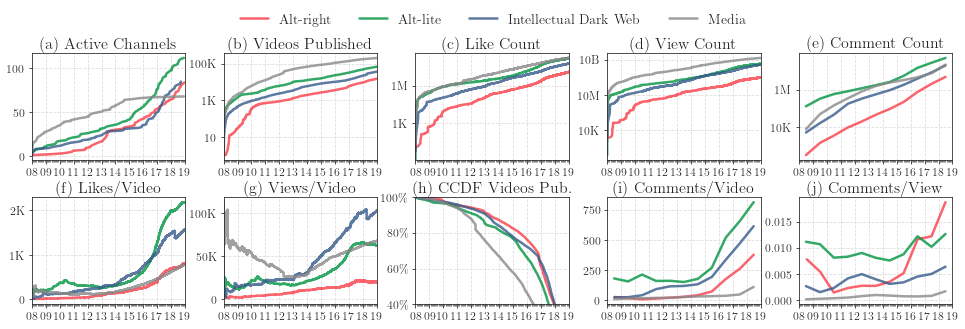

In [19]:
fig = plt.figure(
    constrained_layout=False,
    figsize=(16.5, 4.5),
)
gs = fig.add_gridspec(nrows=2, ncols=5, wspace=0.25, hspace=0.35, top=0.90)

# adds subplots
axs = []
for i in range(10):
    axs.append(fig.add_subplot(gs[i//5, i%5], sharex= axs[0] if i > 0 else None))

# auxiliary vars
qts = [ 
    lambda x: np.cumsum(len(x) * [1]), 
    lambda x: np.cumsum(len(x) * [1]),
    lambda x: np.cumsum(x.like_count).values,
    lambda x: np.cumsum(x.view_count).values
]

dfs = [df.groupby(["name", "category"]).min().reset_index(), df, df, df]
upper_tts = ["(a) Active Channels", "(b) Videos Published", "(c) Like Count", "(d) View Count"]
ys = ["dummy", "dummy", "like_count", "view_count"]
ests =  ["sum", "mean", "mean", "mean"]

quantities = {}

# Plots cdfs on the top plots
for ax, qt, tt, _df  in zip(axs[:4], qts, upper_tts, dfs):
    max_v, min_v, max_cat = 0, 1, {}

    # Gets maximum value for category
    for cat in cats:
        df_tmp = _df.loc[_df.category == cat].sort_values("upload_date_ts")
        quantity = qt(df_tmp)
        max_v = max(max_v, max(quantity))
        max_cat[cat] = max(quantity)

    # Plot cdfs
    for cat in cats:
#         print("-"*50 + "\n" + cat  + "\n" +  "-"*50 )
        df_tmp = _df.loc[_df.category == cat].sort_values("upload_date_ts")
        time = df_tmp.upload_date.values
        quantity = qt(df_tmp)
        quantity_p = quantity / max_cat[cat]
        quantities[(tt, cat)] = (time, quantity)
        
        if tt == "(c) Like Count":
            ax.plot(time, quantity, "-", alpha=0.8, linewidth=2.5, color=colors[cat], 
                    label="Media" if cat is "Control" else cat)
        else:
            ax.plot(time, quantity, "-", alpha=0.8, linewidth=2.5, color=colors[cat])
            
        if tt == "(b) Videos Published":
            axs[7].plot(time, 1 - quantity_p, "-", alpha=0.8, linewidth=2.5, color=colors[cat])
            
#         if tt == "(a) Active Channels":
#             print(list(zip(time, quantity)))

    
    # Sets ticks, titles and limits
    ax.set_title(tt, pad=5)
#     ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xlim([datetime(2008, 1, 1), datetime(2019, 1, 1)])
    
axs[7].set_title("(h) CCDF Videos Pub.", pad=5)
axs[7].set_ylim([0.4, 1])
axs[7].set_yticks([0.4, 0.6, 0.8, 1])
axs[7].set_yticklabels(["40\%", "60\%", "80\%", "100\%"])


for ax in axs[1:5]:
    ax.set_yscale("log")
    
# Adds legend on the top
leg = axs[2].legend(loc='upper center',
           bbox_to_anchor=(0.5, 1.5),
           ncol=4,
           fancybox=False,
           shadow=False,
           frameon=False,
           edgecolor=None,
           fontsize=14)


#  plot comments count
tmp = df_cm
tmp["keep"] = tmp.category.apply(lambda x: x in cats and x != "")
tmp = tmp.loc[tmp["keep"]]
tmp["keep"] = tmp.idx.apply(lambda x: x not in ["", "2006", "2007"])
tmp = tmp.loc[tmp["keep"]]
tmp["idxvv"] = tmp.apply(lambda x: datetime.strptime(dict(x)["idx"], "%Y") + timedelta(days=365/2),  axis=1)
tmp = tmp.groupby(["category", "idxvv"]).sum()
tmp = tmp.reset_index()
tmp["countc"] = tmp.groupby("category")["count"].transform(pd.Series.cumsum)
for cat in cats:
    tmp2 = tmp.loc[tmp.category == cat]
    axs[4].plot(tmp2.idxvv.values, tmp2.countc.values, "-", alpha=0.8, linewidth=2.5, color=colors[cat])

axs[4].set_yscale("log")
axs[4].set_title("(e) Comment Count")

# plots like/video and views/video
for cat in cats:
    axs[5].plot(quantities["(c) Like Count", cat][0], 
             quantities["(c) Like Count", cat][1]/quantities[("(b) Videos Published", cat)][1],
             "-", alpha=0.8, linewidth=2.5, color=colors[cat])
    axs[6].plot(quantities["(d) View Count", cat][0], 
             quantities["(d) View Count", cat][1]/quantities[("(b) Videos Published", cat)][1],
             "-", alpha=0.8, linewidth=2.5, color=colors[cat])
axs[5].set_title("(f) Likes/Video", pad=5)
axs[6].set_title("(g) Views/Video", pad=5)


for cat in cats:
    _tmp = tmp.loc[tmp.category == cat]
    xs = []
    ys_cm_per_video, ys_cm_per_like, ys_cm_per_view = [], [], []
    counts = []
    for idx, i in _tmp.iterrows():
        category, ts, _, _, count = i.values
        if ts.year < 2008:
              continue
        i = dict(i)
        # gets argdate
        argmin_date = np.argmin(abs(quantities["(c) Like Count", i["category"]][0] - np.datetime64(ts)))
        xs.append(quantities["(c) Like Count", i["category"]][0][argmin_date])
        videos_published = fill_nan(quantities["(b) Videos Published", i["category"]][1])[argmin_date]
        likes = fill_nan(quantities["(c) Like Count", i["category"]][1])[argmin_date]
        views = fill_nan(quantities["(d) View Count", i["category"]][1])[argmin_date]
        ys_cm_per_video.append(count/videos_published)
        ys_cm_per_like.append(count/likes)
        ys_cm_per_view.append(count/views)
        counts.append((count, likes, argmin_date))
    axs[8].plot(xs, ys_cm_per_video, "-", alpha=0.8, linewidth=2.5, color=colors[cat])
    axs[9].plot(xs, ys_cm_per_view, "-", alpha=0.8, linewidth=2.5, color=colors[cat])
axs[8].set_title("(i) Comments/Video", pad=5)
axs[9].set_yticks([0, 0.005, 0.01, 0.015])
axs[9].set_title("(j) Comments/View", pad=5)


# Common axis config, grids, etc
for idx, ax in enumerate(axs):
    ax.xaxis.set_major_locator(matdates.YearLocator())
    ax.xaxis.set_minor_locator(matdates.MonthLocator())
    ax.xaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.yaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.xaxis.set_major_formatter(matdates.DateFormatter('%Y'))
    if idx != 9 and idx != 7:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_format))
    
    ax.set_xticklabels([str(v)[2:] for v in list(range(2008,2020)) ])
    ax.set_xlabel("")
    ax.set_ylabel("")

# Saves figs
fig.savefig("../imgs/overview.pdf", bbox_inches='tight')
fig.savefig("../imgs/overview.png", bbox_inches='tight')

## Top Channels Table

In [20]:
# Makes nice table with top channels
tmp, tmp_helper = {}, []

for idx, cat in enumerate(cats):
    df_cat_sum = df.loc[df.category == cat].groupby(["name"]).sum()
    print(cat, len(df_cat_sum))
    names = df_cat_sum.sort_values("view_count", ascending=False).head(16).index.values
    tmp[cat] = names
    tmp_helper += [{"category": c, "name": n, "pos": p} 
                   for c, n, p in zip([cat]*len(names), names, np.arange(16)+1)]
            
    tmp["View Count" + " "*idx] = [
        human_format(num) for num in df_cat_sum.sort_values(
            "view_count", ascending=False).head(16).view_count.values
    ]
    
df_helper = pd.DataFrame(tmp_helper)
df_helper.to_csv(SRC + "important_channels.csv", index=False)

df_table = pd.DataFrame(tmp)
df_table.index += 1
df_table
# print(df_table.to_latex())

Alt-right 84
Alt-lite 112
Intellectual Dark Web 85
Control 68


,Alt-right,View Count,Alt-lite,View Count,Intellectual Dark Web,View Count,Control,View Count
1,James Allsup,62M,StevenCrowder,727M,PowerfulJRE,1B,vox,1B
2,Black Pigeon Speaks,50M,Rebel Media,405M,JRE Clips,717M,gq magazine,1B
3,ThuleanPerspective,45M,Paul Joseph Watson,356M,PragerUniversity,635M,vice news,1B
4,Red Ice TV,42M,MarkDice,334M,The Daily Wire,247M,wired magazine,1B
5,The Golden One,12M,SargonofAkkad100,258M,The Rubin Report,206M,vanity fair,639M
6,AmRenVideos,9M,Stefan Molyneux,193M,ReasonTV,138M,the verge,636M
7,NeatoBurrito Productions,7M,hOrnsticles3,145M,JordanPetersonVideos,90M,glamour magazine,620M
8,The Last Stand,7M,MILO,133M,Bite-sized Philosophy,62M,business insider,523M
9,MillennialWoes,6M,Styxhexenhammer666,132M,Owen Benjamin,35M,huffington post (huffpost),329M
10,Mark Collett,6M,OneTruth4Life,112M,AgatanFoundation,33M,today i found out,328M


In [21]:
df_sources = pd.read_csv(SRC+ "sources_final_trimmed.csv")

df_sources.loc[df_sources["Data Collection step"] == 4, "Data Collection step"] = 3

tmp = {}
tmp_helper = []

def eq_size(nparray, desired_len=24):
    return np.array(list(nparray) + [None]*(desired_len - len(nparray)))

for idx, cat in enumerate(cats_to_control):
    if cat == "Control":
        continue

    df_src_tmp = df_sources.loc[df_sources.Category == cat]
    df_src_tmp = df_src_tmp.sort_values(by=['Category', "Data Collection step", "Name"])
    
    tmp[cat + " names"] = eq_size(df_src_tmp.Name.values)
    

df_table = pd.DataFrame(tmp)
df_table
# print(df_table.to_latex())

,left names,center names,left-center names,right-center names,right names
0,cosmopolitan,big think,(the)atlantic,forbes,american enterprise institute
1,democracy now,c-span,business insider,gulf news,judicial watch
2,elite daily,consumer reports,cbc news,learn liberty,national rifle association (nra)
3,good magazine,financial times,engadget,new york post,pj media
4,gq magazine,harvard business review,feminist frequency,ntd.tv (new tang dynasty),project veritas
5,huffington post (huffpost),investopedia,glamour magazine,russia insider,ron paul liberty report
6,mashable,makeuseof,global citizen,None,None
7,merry jane,mental floss,global news,None,None
8,new york magazine,military.com,hollywood reporter,None,None
9,new yorker,recode,la times,None,None


# Find number of users and of comments

In [22]:
authors_dict = SqliteDict(SRC + "/helpers/authors_dict.sqlite", tablename="authors")

num_authors = 0
num_comments = 0

for _, items in authors_dict.items():
    tmp = len([i for i in items if i["category"] in cats if i["channel_id"] in df_sources.Id.values])
    num_comments += tmp
    if tmp > 0:
        num_authors += 1


print("We have {} comments from {} users being analysed!".format(num_comments, num_authors))

We have 72069878 comments from 5954638 users being analysed!


## Interannotator Agreement

In [25]:
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import cohens_kappa, to_table

df_ann = pd.read_csv(SRC + "/helpers/interan.csv")
idx = (df_ann.ann1.values, df_ann.ann2.values)
cohen_kappa_score(df_ann.ann1.values, df_ann.ann2.values)

0.7525328261585166

In [26]:
a = np.c_[df_ann.ann1.values, df_ann.ann2.values]
a[a == "Alt-right"] = 0
a[a == "Alt-lite"] = 1
a[a == "Intellectual Dark Web"] = 2
a[a == "NONE"] = 3
table, _ = to_table(a)
cohens_kappa(table)

{'kind': 'Simple',
 'kappa': 0.7525328261585166,
 'kappa_max': 0.8981017519476243,
 'weights': None,
 'var_kappa': 0.0015431761944680773,
 'var_kappa0': 0.0019407890352261471,
 'alpha': 0.025,
 'alpha_ci': '  95',
 'std_kappa': 0.03928328136075292,
 'std_kappa0': 0.04405438724152394,
 'z_value': 17.081904284193712,
 'pvalue_one_sided': 1.0120192808013677e-65,
 'pvalue_two_sided': 2.0240385616027354e-65,
 'kappa_low': 0.6755390094968873,
 'kappa_upp': 0.8295266428201459,
 'distribution_kappa': <scipy.stats._distn_infrastructure.rv_frozen at 0x1281aedd0>,
 'distribution_zero_null': <scipy.stats._distn_infrastructure.rv_frozen at 0x12a5c2110>}

## Table Views

In [ ]:
tmp = df_cm
tmp["keep"] = tmp.category.apply(lambda x: x in cats and x != "")
tmp = tmp.loc[tmp["keep"]]
tmp["keep"] = tmp.idx.apply(lambda x: x not in ["", "2006", "2007"])
tmp = tmp.loc[tmp["keep"]]
tmp.groupby(["category", "idx"]).sum()

pd.set_option('display.float_format', lambda x: '%.1f' % x)
df_views_helper = df.groupby(["category", "upload_year"]).sum().reset_index()
df_views_helper["idx_str"] = df_views_helper.upload_year.apply(lambda x: str(x)[:4])

df_c = pd.concat([tmp.groupby(["category", "idx"]).sum(), 
           df_views_helper.rename(columns={"idx_str":"idx"}).set_index(["category", "idx"])], axis=1, sort=False)
df_c = df_c.reset_index()

df_c = df_c[["category", "idx", "like_count", "view_count", "dummy", "count"]]
df_c = df_c.rename(columns={"idx":"Year",
                            "category":"Category",
                            "like_count": "Like Count",
                            "view_count": "View Count",
                            "dummy": "Video Count", 
                            "count": "Comment Count"}).set_index("Category")
# df_c.to_csv("../data/df_views_like_video.csv")
# print(df_c.to_latex())
df_c

/Users/horta/opt/anaconda3/envs/youtube/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Year,Like Count,View Count,Video Count,Comment Count
Category,,,,,
Alt-lite,2008,272639.0,18145720.0,1392,129130
Alt-lite,2009,585060.0,32993863.0,929,197934
Alt-lite,2010,503744.0,30519109.0,1498,248432
Alt-lite,2011,527221.0,28400257.0,2344,236961
Alt-lite,2012,805166.0,61779929.0,4142,360688
Alt-lite,2013,1237131.0,101136564.0,2476,531614
Alt-lite,2014,2574586.0,158822748.0,3319,824757
Alt-lite,2015,8227303.0,398745164.0,7299,2787437
Alt-lite,2016,27277364.0,1001985084.0,9442,8983525
